<a href="https://colab.research.google.com/github/todnewman/coe_training/blob/master/Basic_Convolutional_Neural_Nets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Basic Convolutional Neural Networks
**Author**: W. Tod Newman

**Updates**: New Version

## Problem

Use a convolutional neural network (CNN) to classify images from the "Fashion MNIST" data set,  Evaluate different numbers of neurons, kernel sizes, etc. and their impact on performance.

Additionally, this notebook shows how to:
1.  Follow a managed workflow from Data to Verification.  This uses GitHub, Google Drive, and Tensorboard to demonstrate what a production workflow might look like.
2.  Connect a Keras/Tensorflow model with SKLearn and Pandas tools
3.  Use Tensorboard for Evaluating models

## Learning Objectives


* Evaluate how CNN parameters impact classification accuracy and training time..
* Evaluate model results using Tensorboard

## Dataset

This dataset is the Fashion MNIST dataset

Fashion-MNIST is a dataset of Zalando's article images—consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes. Zalando intends Fashion-MNIST to serve as a direct drop-in replacement for the original MNIST dataset for benchmarking machine learning algorithms. It shares the same image size and structure of training and testing splits.

Each image is 28 pixels in height and 28 pixels in width, for a total of 784 pixels in total. Each pixel has a single pixel-value associated with it, indicating the lightness or darkness of that pixel, with higher numbers meaning darker. This pixel-value is an integer between 0 and 255. The training and test data sets have 785 columns. The first column consists of the class labels (see above), and represents the article of clothing. The rest of the columns contain the pixel-values of the associated image.

The Labels are:  
0 T-shirt/top
1 Trouser
2 Pullover
3 Dress
4 Coat
5 Sandal
6 Shirt
7 Sneaker
8 Bag
9 Ankle boot 



In [0]:
import keras
from keras.datasets import fashion_mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten,  Conv2D, MaxPooling2D
from keras import backend as K
from keras.callbacks import EarlyStopping
from sklearn import metrics
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import os
%matplotlib inline
os.environ['TF_CPP_MIN_LOG_LEVEL'] = "2"
tensorboard = False

Using TensorFlow backend.


# Code to allow you to connect to Tensorboard from CoLaboratory
As you probably know, your Google Colab virtual machine is running on a local network located in a Google's server room, while your local machine could be anywhere else in the world.

How then can we access the TensorBoard page from our local machine?

Fortunately there's a free service named ngrok that will allow us to connect to the Tensorboard connection on our Web browser.

## Step One: Get the ngrok image from its stable location, then unzip it. 
Remember, this is all being done in the Google environment, so don't worry about your firewall...
ngrok is pretty useful for testing.  Find more at https://ngrok.com/

## Step Two: Connect Tensorboard

Note that this gives a link to the Tensorboard URL at the end.  Train the model first and then click the  link below (will have ngrok.io at the end) to see results in Tensorboard.

Here's a link with basic info on Tensorboard:  https://www.tensorflow.org/guide/summaries_and_tensorboard

## Step Three: Run TensorBoard

## Step Four:  Run ngrok and grab the URL that the Tensorboard instance will be hosted at.
The URL below (in blue) is what you click on to see your Tensorboard instance after you train the CNN.

In [0]:
if not tensorboard:
    !wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
    !unzip ngrok-stable-linux-amd64.zip
LOG_DIR = './log'
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
    .format(LOG_DIR)
)
get_ipython().system_raw('./ngrok http 6006 &')
! curl -s http://localhost:4040/api/tunnels | python3 -c \
"import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

    
tensorboard = True

--2019-04-17 22:19:54--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 54.152.127.232, 34.232.181.106, 52.4.95.48, ...
Connecting to bin.equinox.io (bin.equinox.io)|54.152.127.232|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14977695 (14M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip’

ngrok-stable-linux- 100%[===================>]  14.28M  34.4MB/s    in 0.4s    

2019-04-17 22:19:55 (34.4 MB/s) - ‘ngrok-stable-linux-amd64.zip’ saved [14977695/14977695]

Archive:  ngrok-stable-linux-amd64.zip
  inflating: ngrok                   
https://870a9d5a.ngrok.io


## Set Up Variables

In [0]:
epochs = 10
num_classes = 10
batch_size = 128
img_rows, img_cols = 28, 28

## Gather and Process Fashion MNIST data

1. First, collect the data from Keras (our goal is someday that our organizational data is this easy to get!)
2. Then split into train and test sets.
3. Next we need to process the data into the proper shape for the CNN
4. Then scale the floats to land between 0 and 1.  Often times we use sklearn's MinMaxScaler for this, but in this case we're going for simplicity.
5. Next take the y_train and y_test labels and encode them one-hot.  This will enable the CNN to function.

In [0]:
mnist_data = fashion_mnist.load_data()
x = mnist_data[0][0]
y = mnist_data[0][1]


x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42)

if K.image_data_format() == "channels first":
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)
    
x_train = x_train.astype("float32")
x_test = x_test.astype("float32")
x_train /= 225
x_test /= 225

# Convert Class Vector to Binary Class Matrices.

y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
print(y_test.shape)

def decode_one_hot(y):
    y_classes = [np.argmax(yi, axis=None, out=None) for yi in y]
    return y_classes

(19800, 10)


## Build the Model

In [0]:
from keras.callbacks import TensorBoard

model = Sequential()
model.add(Conv2D(20, kernel_size=(5,5), strides=(2,2), activation="relu", input_shape=input_shape))
#model.add(MaxPooling2D(pool_size=(2,2)))
#model.add(Conv2D(32, kernel_size=(3,3), activation="relu"))
model.add(Dropout(0.6))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense(128, activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(num_classes, activation="softmax"))


model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adadelta(), metrics=['accuracy'])

tbCallBack = TensorBoard(log_dir='./log', histogram_freq=1,
                         write_graph=True,
                         write_grads=True,
                         batch_size=batch_size,
                         write_images=True)

# Having trouble getting tensorboard callback to work well with EarlyStopping callback...
if not tensorboard:
    my_callbacks = [EarlyStopping(monitor="acc", patience=5)]
else:
    my_callbacks = [tbCallBack]

## Fit and Evaluate the Model

In [0]:
from sklearn import metrics

%cd /content/drive/'My Drive'/

retrain = False
weights_file = 'cnn_fashion_mnist'

if not retrain:
    model.load_weights(weights_file) 

hist = model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test),
          callbacks=my_callbacks)

score = model.evaluate(x_test, y_test)

weights_file = 'cnn_fashion_mnist'
model.save_weights(weights_file, overwrite=True)

yhat = model.predict_classes(x_test).astype(int)
y_dec = decode_one_hot(y_test)
print(metrics.classification_report(y_dec, yhat))
print("Testing Loss:", score[0])
print("Testing Accuracy:", score[1])

model.summary()



/content/drive/My Drive
Train on 40200 samples, validate on 19800 samples
Epoch 1/10
40200/40200 [==============================] - 10s 251us/step - loss: 0.4011 - acc: 0.8568 - val_loss: 0.3160 - val_acc: 0.8862
Epoch 2/10
40200/40200 [==============================] - 10s 245us/step - loss: 0.3830 - acc: 0.8637 - val_loss: 0.3130 - val_acc: 0.8925
Epoch 3/10
40200/40200 [==============================] - 10s 245us/step - loss: 0.3614 - acc: 0.8700 - val_loss: 0.3093 - val_acc: 0.8921
Epoch 4/10
40200/40200 [==============================] - 10s 248us/step - loss: 0.3558 - acc: 0.8717 - val_loss: 0.3069 - val_acc: 0.8923
Epoch 5/10
40200/40200 [==============================] - 10s 245us/step - loss: 0.3479 - acc: 0.8736 - val_loss: 0.3090 - val_acc: 0.8922
Epoch 6/10
40200/40200 [==============================] - 10s 255us/step - loss: 0.3400 - acc: 0.8760 - val_loss: 0.3041 - val_acc: 0.8965
Epoch 7/10
40200/40200 [==============================] - 10s 245us/step - loss: 0.3403 - ac

## Plot the accuracy vs. validation accuracy

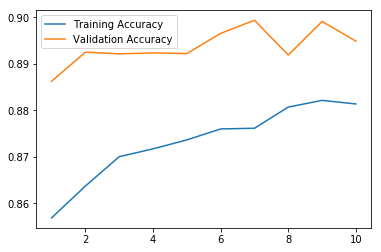

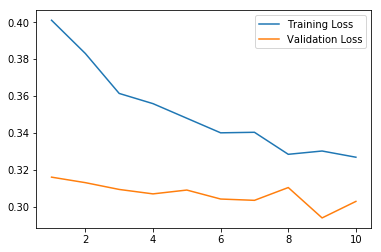

In [0]:
epoch_list = list(range(1, len(hist.history['acc']) + 1))
plt.plot(epoch_list, hist.history['acc'], epoch_list, hist.history['val_acc'])
plt.legend(("Training Accuracy", "Validation Accuracy"))
plt.show()

plt.plot(epoch_list, hist.history['loss'], epoch_list, hist.history['val_loss'])
plt.legend(("Training Loss", "Validation Loss"))
plt.show()

In [0]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/'My Drive'/
#%ls

/content/drive/My Drive
/content/drive/My Drive
total 4097
drwx------ 2 root root    4096 Jul 21  2018  baseball/
-rw------- 1 root root  394368 Apr 17 22:54  cnn_fashion_mnist
drwx------ 2 root root    4096 Jul 21  2018  Colab/
drwx------ 2 root root    4096 Aug  6  2018 'Colab Notebooks'/
drwx------ 2 root root    4096 Jul 25  2018  Colab_Notebooks/
drwx------ 3 root root    4096 Apr 17 22:53  data/
drwx------ 2 root root    4096 Jul 22  2018 'Fusion Tables'/
-rw------- 1 root root  238376 Apr 16 21:39  id_model
-rw------- 1 root root       1 Nov 28  2011 'Imported from Google Notebook - My Notebook.gdoc'
-rw------- 1 root root      65 Mar 14 17:27  kaggle.json
-rw------- 1 root root  125424 Jul 24  2018  lunarlander
drwx------ 2 root root    4096 Oct 23 15:17  Misc/
-rw------- 1 root root  108024 Mar  2 07:17  rain_model
-rw------- 1 root root  105920 Mar  4 15:28  rain_model_10k_dropout.2
-rw------- 1 root root  122424 Mar  3 19:01  rain_model_5k_dropout.3
-rw------- 1 root root  1